In [11]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from prophet import Prophet
import ta

# Step 1: Choose multiple stock tickers
tickers = ['AAPL', 'GOOGL', 'MSFT']  # You can add more here

# Loop through each ticker
for ticker in tickers:
    print(f"\n Processing stock: {ticker}")

tickers = ['MSFT', 'AAPL', 'GOOGL', 'TSLA']
data = yf.download(tickers, start='2020-01-01', end='2023-12-31', group_by='ticker')


# Flatten to multiindex (Price, Ticker)
df = pd.concat({ticker: data[ticker]['Close'] for ticker in tickers}, axis=1)
df.columns.names = ['Ticker']
df = df.stack().to_frame(name='Close').unstack().swaplevel(axis=1).sort_index(axis=1)


[*********************100%***********************]  4 of 4 completed


 Processing stock: AAPL

 Processing stock: GOOGL

 Processing stock: MSFT


In [ ]:
# Step 2: Download data
stock_df = data[ticker][['Close']].reset_index()



In [14]:
# Step 3: Add financial indicators
# Ensure you extract a 1D Series, not a DataFrame
if isinstance(stock_df['Close'], pd.DataFrame) or len(stock_df['Close'].shape) > 1:
    close_series = stock_df['Close'].squeeze()  # flatten to 1D if needed
else:
    close_series = stock_df['Close']

# Apply TA indicators (MUST use 1D Series)
stock_df['SMA_20'] = ta.trend.SMAIndicator(close=close_series, window=20).sma_indicator()
stock_df['EMA_20'] = ta.trend.EMAIndicator(close=close_series, window=20).ema_indicator()
stock_df['RSI'] = ta.momentum.RSIIndicator(close=close_series, window=14).rsi()

bb = ta.volatility.BollingerBands(close=close_series, window=20)
stock_df['BB_upper'] = bb.bollinger_hband()
stock_df['BB_lower'] = bb.bollinger_lband()

# Remove any rows with NaNs (first few due to window)
stock_df.dropna(inplace=True)


In [15]:
# 🔹 Step 4: Anomaly Detection using Isolation Forest
features = stock_df[['Close', 'SMA_20', 'EMA_20', 'RSI', 'BB_upper', 'BB_lower']]
model = IsolationForest(contamination=0.01, random_state=42)
model.fit(features)
stock_df['anomaly'] = model.predict(features)


Forecasting for: MSFT


13:33:00 - cmdstanpy - INFO - Chain [1] start processing
13:33:01 - cmdstanpy - INFO - Chain [1] done processing


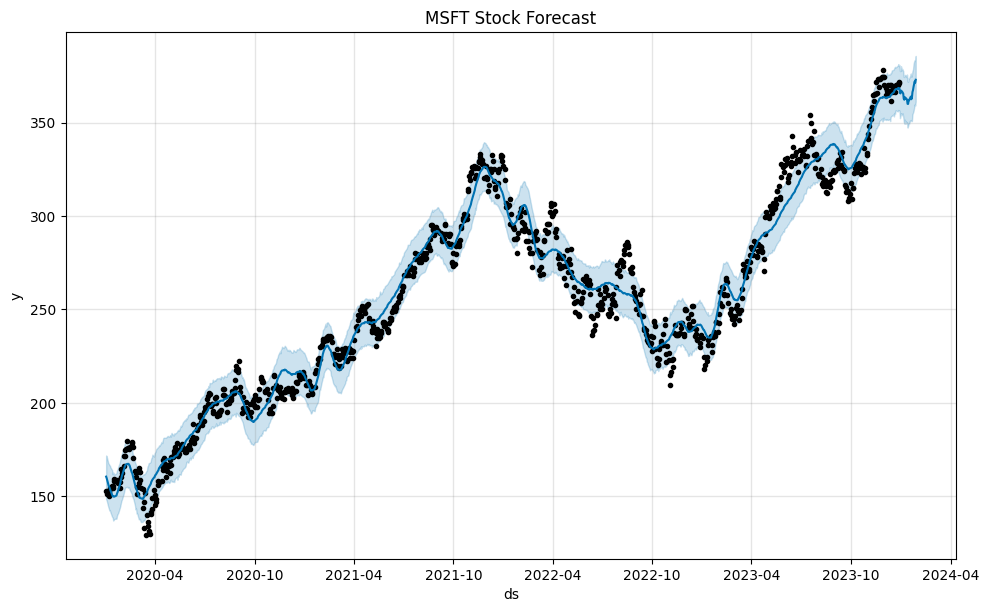


Forecasting for: AAPL


13:33:01 - cmdstanpy - INFO - Chain [1] start processing
13:33:02 - cmdstanpy - INFO - Chain [1] done processing


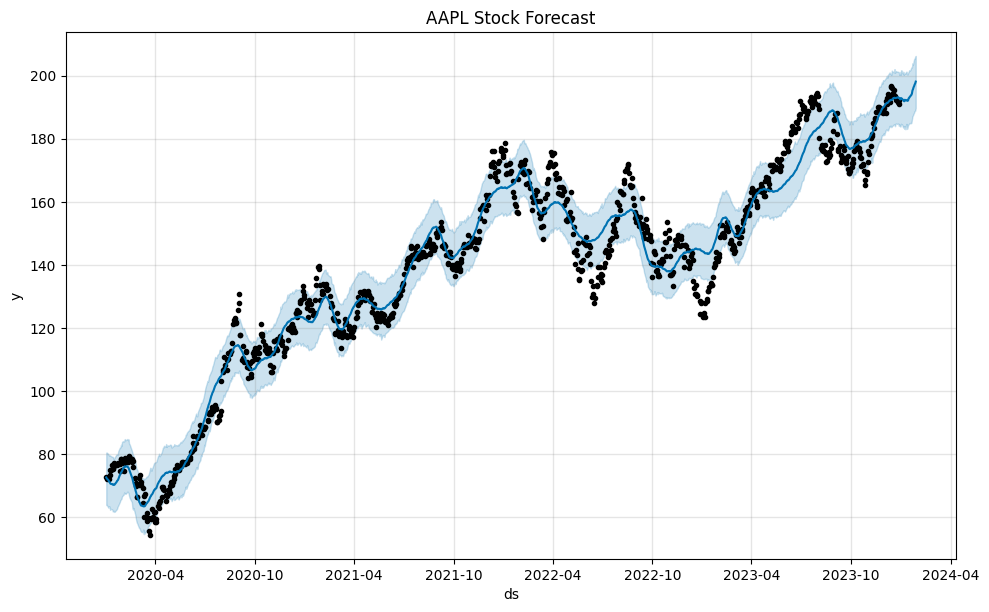


Forecasting for: GOOGL


13:33:03 - cmdstanpy - INFO - Chain [1] start processing
13:33:03 - cmdstanpy - INFO - Chain [1] done processing


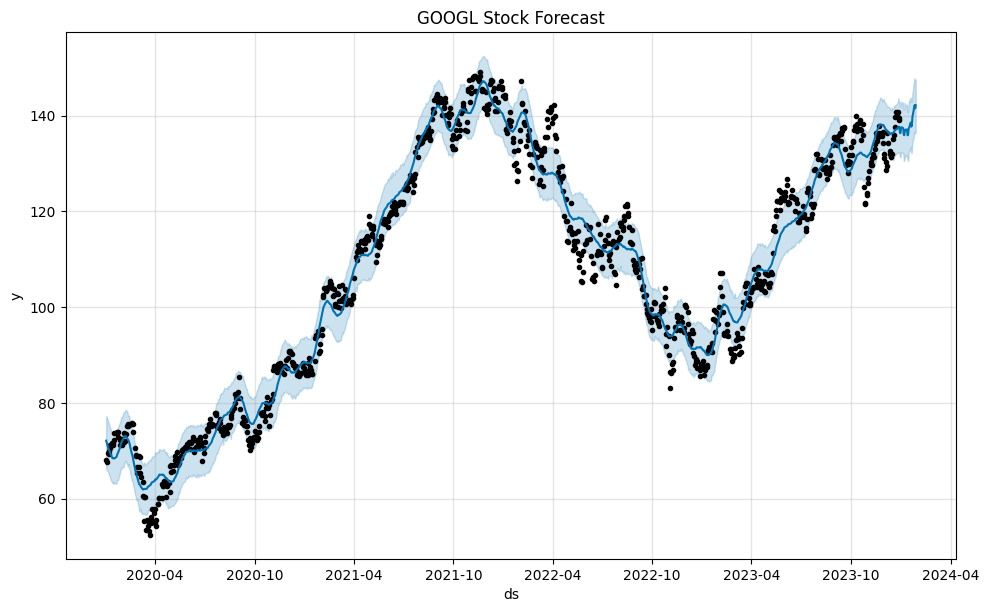


Forecasting for: TSLA


13:33:04 - cmdstanpy - INFO - Chain [1] start processing
13:33:04 - cmdstanpy - INFO - Chain [1] done processing


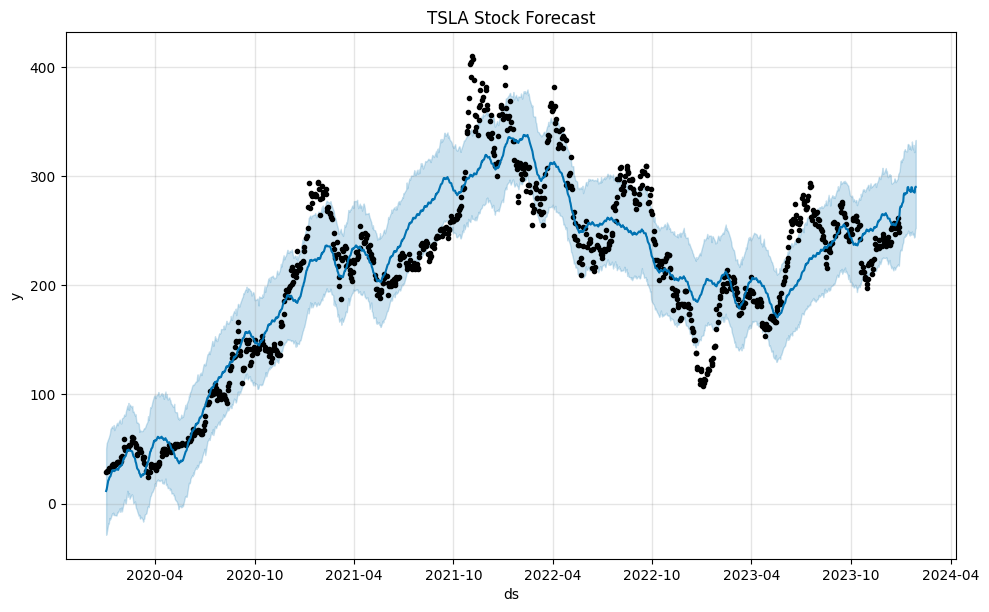

In [16]:
# Step 5: Forecast each stock
for ticker in tickers:
    print(f"\nForecasting for: {ticker}")
    try:
        # Extract single ticker data from multi-ticker dataframe
        stock_df = data[ticker][['Close']].reset_index()

        # Rename columns for Prophet
        stock_df.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

        # Drop any missing values
        stock_df.dropna(inplace=True)

        # Fit Prophet model
        model = Prophet(daily_seasonality=True)
        model.fit(stock_df)

        # Create future dataframe for predictions
        future = model.make_future_dataframe(periods=30)
        forecast = model.predict(future)

        # Plot forecast
        fig = model.plot(forecast)
        plt.title(f"{ticker} Stock Forecast")
        plt.show()

    except Exception as e:
        print(f"Error processing {ticker}: {e}")
